In [12]:
import sys
sys.path.append("../")
import logging

import peexcel.utils.nextcloud
from peexcel.utils.targets import Zielwert

var_path = r"EE\6_Daten\Quartiere"
letztstand = r"EE\6_Daten\Quartiere\.VERZEICHNISSE\Quartiersvergleich211129cleaned.xlsx"
sheet_name = "PEExcel Import"
index_col = "longname"
file = peexcel.utils.nextcloud.get(letztstand)


In [13]:
import pandas as pd
from openpyxl import load_workbook

df = pd.read_excel(file, sheet_name=sheet_name, header=2, index_col=index_col)
df2 = pd.read_excel(r"Quartiersvergleich_bruessel.xlsx", sheet_name=sheet_name, header=0, index_col=index_col)

In [14]:
df2

,PE_Saldo,GFZ,PE-Saldo Zielwert [kWh/m²NGF],PE-Saldo Ziel Real[kWh/m²BGF],PE-Saldo Zielwert Großkraftwerke [kWh/m²NGF]
longname,,,,,
Foyer Laekenois - Basic,-143.0,1.3,8,-135,-143
Foyer Laekenois - AC 2050,NaN,1.3,8,-75,-83
Foyer Laekenois - Al 2040,NaN,1.3,8,-79,-87
Foyer Laekenois - Al 2050,NaN,1.3,8,-72,-80
Masui - Basic,NaN,2.9,25,-261,-286
Masui - AC 2050,NaN,2.9,25,-57,-82
Masui - Al 2040,NaN,2.9,25,-67,-92
Masui - Al 2050,NaN,2.9,25,-49,-74
Maximilien - Basic,NaN,4.0,31,-141,-172


In [15]:
# clean
# remove empty rows
# remove outdated rows:
# rows that do not have Simualtion = "Doppelsimulation"
df = df.drop(df[(df.FILE != "latest")].index)
df

,idx,Variantenname,Simulation,Berechnungszeitpunkt,FILE,Projekt,Wohnbau NGF (m²),Büro NGF (m²),Schule NGF (m²),Kiga NGF (m²),Handel NGF (m²),Summe NGF (m²),Anteil NonFood an Handel,Bauteilfläche Hülle Außenwand (exkl. Fenster) (m²),Bauteilfläche Hülle Fenster (m²),Bauteilfläche Hülle Dach (m²),Bauteilfläche Hülle Decke gegen Erdreich / Keller (m²),Gewählte Variante,U-Wert Außenwand (exkl. Fenster) (W/m²K),U-Wert Fenster (W/m²K),U-Wert Dach (W/m²K),U-Wert Decke gegen Erdreich / Keller (W/m²K),g-Wert Fenster (W/m²K),"Speicherkapazität spezifisch Wirksame Wärmekapazität (massiv 204, Misch 135, Leicht 60 laut PHPP) (Wh/m²K)",Außenwand (exkl. Fenster) GWP 100S (kg CO2equiv/m²a),Fenster GWP 100S (kg CO2equiv/m²a),Dach GWP 100S (kg CO2equiv/m²a),Decke gegen Erdreich / Keller GWP 100S (kg CO2equiv/m²a),Zwischen-geschoßdecken GWP 100S (kg CO2equiv/m²a),Allgemein baulich GWP 100S (kg CO2equiv/m²a),PV-Anlage GWP 100S (kg CO2equiv/m²a),Erdwärme-sonden GWP 100S (kg CO2equiv/m²a),Komfort-lüftung GWP 100S (kg CO2equiv/m²a),Solarthermie GWP 100S (kg CO2equiv/m²a),Allgemein Haustechnik GWP 100S (kg CO2equiv/m²a),Wärme-brücken-zuschlag,Transmissionsleitwert gesamt (W/K),Durchschn. Raumhöhe für die Berechnung des Lüfungs-volumen (m),Gewinne durch opake Bauteile,Mobiler Sommerlicher Sonnenschutz,...,Kühlen mit Hilfsstrom.1,WW mit Hilfsstrom.1,Summe Haustechnik thermisch.1,Summe Haustechnik elektrisch (ohne Lüftung).1,Summe Haustechnik (ohne Lüftung).1,Allgmeinstrom.1,Beleuchtung.1,Nutzerstrom.1,"Haushaltsstrom (inkl. Lüftung, Nutzerstrom, Allgemeinstrom).1",Elektrische Energie ohne ecars gesamt.1,e-cars.1,fossil-cars.1,Elektrische Energie mit ecars gesamt.1,PV Direktdeckung.1,PV Überdeckung (ohne e-Batterie).1,PV.2,E-Batterie PV.1,E-Batterie Netzdienlichkeit.1,E-Batterie.1,Netzdienlichkeit Direkt- und Überdeckung (ohne E-Batterie).1,Netzstrom.1,Abwärme.1,Summe.1,GFZ,PE-Saldo Zielwert [kWh/m²NGF],PE-Saldo Ziel Real[kWh/m²BGF],PE-Saldo Zielwert Großkraftwerke [kWh/m²NGF],diese zellen sind mit ergbnisverweisen befüllbar,diese zellen sind mit ergbnisverweisen befüllbar.1,ende result saving area,Unnamed: 401,Unnamed: 402,Projektkennwert alfa,Grenzwert,Projektkennwert beta,Grenzwert.1,CO2 Personen Wohnen (t CO2 /Person a),Grenzwert CO2 Person Wohnen,CO2 Gesamt alle Nutzungen (kg CO2 /m² a),Grenzwert CO2 näherungsweise auf m² bezogen (UAP)
longname,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Aichinger 1 Alpha - Bauträger Standard,1,Alpha - Bauträger Standard,Doppelsimulation,2021-11-24 15:11:57,latest,Aichinger,123.8,0.0,0.0,0.0,0.0,123.8,0.00,189.2224,31.2588,87.5,87.5,Bauträger Standard,0.180,0.930000,0.120,0.133000,0.70,180.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.129396,0.456556,2.5,1.065602,0.580000,...,1.731594,7.882112,0.0,19.214654,19.214654,1.629360,0.0,21.144461,26.772908,45.987562,0.000000,0.0,45.987562,13.555886,13.846756,27.402642,0.000000,0.000000,0.000000,0.000000,17.590146,0.0,44.992788,0.234899,121.154503,85.708157,97.91429,0.684,0.916857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aichinger 2 Alpha - Aktuell,2,Alpha - Aktuell,Doppelsimulation,2021-11-24 15:12:07,latest,Aichinger,123.8,0.0,0.0,0.0,0.0,123.8,0.00,189.2224,31.2588,87.5,87.5,Aktuell,0.099,0.791406,0.076,0.059098,0.51,106.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100000,0.364416,2.6,1.065602,0.580000,...,1.947919,7.882112,0.0,14.283625,14.283625,1.629360,0.0,21.144461,26.772908,41.056533,0.000000,0.0,41.056533,13.518382,12.765660,26.284042,0.000000,0.000000,0.000000,0.000000,13.777718,0.0,40.061759,0.234899,121.154503,85.708157,97.91429,0.684,0.830531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aichinger 3 Alpha - Netzdienlichkeit,3,Alpha - Netzdienlichkeit,Doppelsimulation,2021-11-24 15:12:18,latest,Aichinger,123.8,0.0,0.0,0.0,0.0,123.8,0.00,189.2224,31.2588,87.5,87.5,Aktuell,0.099,0.791406,0.076,0.059098,0.51,106.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050000,0.364416,2.6,1.065602,0.580000,...,1.9685

In [16]:
#plotting cols
req_cols = []
# system boundary
for sys in ["Alpha", "Beta", "Omega"]:
    df[sys] = [sys*bool for bool in df.Variantenname.str.contains(sys)]
df["Systemgrenze"] = df["Alpha"] + df["Beta"] + df["Omega"]
req_cols.append("Systemgrenze")

df = df.drop(df[(df.Systemgrenze == "Omega")].index)
df

,idx,Variantenname,Simulation,Berechnungszeitpunkt,FILE,Projekt,Wohnbau NGF (m²),Büro NGF (m²),Schule NGF (m²),Kiga NGF (m²),Handel NGF (m²),Summe NGF (m²),Anteil NonFood an Handel,Bauteilfläche Hülle Außenwand (exkl. Fenster) (m²),Bauteilfläche Hülle Fenster (m²),Bauteilfläche Hülle Dach (m²),Bauteilfläche Hülle Decke gegen Erdreich / Keller (m²),Gewählte Variante,U-Wert Außenwand (exkl. Fenster) (W/m²K),U-Wert Fenster (W/m²K),U-Wert Dach (W/m²K),U-Wert Decke gegen Erdreich / Keller (W/m²K),g-Wert Fenster (W/m²K),"Speicherkapazität spezifisch Wirksame Wärmekapazität (massiv 204, Misch 135, Leicht 60 laut PHPP) (Wh/m²K)",Außenwand (exkl. Fenster) GWP 100S (kg CO2equiv/m²a),Fenster GWP 100S (kg CO2equiv/m²a),Dach GWP 100S (kg CO2equiv/m²a),Decke gegen Erdreich / Keller GWP 100S (kg CO2equiv/m²a),Zwischen-geschoßdecken GWP 100S (kg CO2equiv/m²a),Allgemein baulich GWP 100S (kg CO2equiv/m²a),PV-Anlage GWP 100S (kg CO2equiv/m²a),Erdwärme-sonden GWP 100S (kg CO2equiv/m²a),Komfort-lüftung GWP 100S (kg CO2equiv/m²a),Solarthermie GWP 100S (kg CO2equiv/m²a),Allgemein Haustechnik GWP 100S (kg CO2equiv/m²a),Wärme-brücken-zuschlag,Transmissionsleitwert gesamt (W/K),Durchschn. Raumhöhe für die Berechnung des Lüfungs-volumen (m),Gewinne durch opake Bauteile,Mobiler Sommerlicher Sonnenschutz,...,Summe Haustechnik (ohne Lüftung).1,Allgmeinstrom.1,Beleuchtung.1,Nutzerstrom.1,"Haushaltsstrom (inkl. Lüftung, Nutzerstrom, Allgemeinstrom).1",Elektrische Energie ohne ecars gesamt.1,e-cars.1,fossil-cars.1,Elektrische Energie mit ecars gesamt.1,PV Direktdeckung.1,PV Überdeckung (ohne e-Batterie).1,PV.2,E-Batterie PV.1,E-Batterie Netzdienlichkeit.1,E-Batterie.1,Netzdienlichkeit Direkt- und Überdeckung (ohne E-Batterie).1,Netzstrom.1,Abwärme.1,Summe.1,GFZ,PE-Saldo Zielwert [kWh/m²NGF],PE-Saldo Ziel Real[kWh/m²BGF],PE-Saldo Zielwert Großkraftwerke [kWh/m²NGF],diese zellen sind mit ergbnisverweisen befüllbar,diese zellen sind mit ergbnisverweisen befüllbar.1,ende result saving area,Unnamed: 401,Unnamed: 402,Projektkennwert alfa,Grenzwert,Projektkennwert beta,Grenzwert.1,CO2 Personen Wohnen (t CO2 /Person a),Grenzwert CO2 Person Wohnen,CO2 Gesamt alle Nutzungen (kg CO2 /m² a),Grenzwert CO2 näherungsweise auf m² bezogen (UAP),Alpha,Beta,Omega,Systemgrenze
longname,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Aichinger 1 Alpha - Bauträger Standard,1,Alpha - Bauträger Standard,Doppelsimulation,2021-11-24 15:11:57,latest,Aichinger,123.8,0.0,0.0,0.0,0.0,123.8,0.00,189.2224,31.2588,87.5,87.5,Bauträger Standard,0.180,0.930000,0.120,0.133000,0.70,180.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.129396,0.456556,2.5,1.065602,0.580000,...,19.214654,1.629360,0.0,21.144461,26.772908,45.987562,0.000000,0.0,45.987562,13.555886,13.846756,27.402642,0.000000,0.000000,0.000000,0.000000,17.590146,0.0,44.992788,0.234899,121.154503,85.708157,97.91429,0.684,0.916857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alpha,,,Alpha
Aichinger 2 Alpha - Aktuell,2,Alpha - Aktuell,Doppelsimulation,2021-11-24 15:12:07,latest,Aichinger,123.8,0.0,0.0,0.0,0.0,123.8,0.00,189.2224,31.2588,87.5,87.5,Aktuell,0.099,0.791406,0.076,0.059098,0.51,106.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100000,0.364416,2.6,1.065602,0.580000,...,14.283625,1.629360,0.0,21.144461,26.772908,41.056533,0.000000,0.0,41.056533,13.518382,12.765660,26.284042,0.000000,0.000000,0.000000,0.000000,13.777718,0.0,40.061759,0.234899,121.154503,85.708157,97.91429,0.684,0.830531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alpha,,,Alpha
Aichinger 3 Alpha - Netzdienlichkeit,3,Alpha - Netzdienlichkeit,Doppelsimulation,2021-11-24 15:12:18,latest,Aichinger,123.8,0.0,0.0,0.0,0.0,123.8,0.00,189.2224,31.2588,87.5,87.5,Aktuell,0.099,0.791406,0.076,0.059098,0.51,106.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050000,0.364416,2.6,1.065602,0.580000,...,14.340652,1.454160,0.0,21.144461,26.597708,40.938361,0.000000,0.0,40.938361,13.433507,9.058098,22.491605,0.000000,0.000000,0.000000,11.234784,6.217

# project
req_cols.append("Projekt")
# mobility measures
df["Mobilität"] = ["Klima:Aktiv Standard"* (not b) for b in df.idx.astype(str).str.contains("ob")]
df["Mobilität"] += ["Optimiert"*b for b in df.idx.astype(str).str.contains("ob")]
df["Mobilität"]

In [17]:
# PE-saldo Projektwert
# depends on energy system
df["id"] = df.idx.astype(str).str.extract("(^\d)").astype(int)
df.id

longname
Aichinger 1 Alpha - Bauträger Standard          1
Aichinger 2 Alpha - Aktuell                     2
Aichinger 3 Alpha - Netzdienlichkeit            3
Aichinger 4 Alpha - Min PEQ                     4
Aichinger 5 Beta - Bauträger Standard           5
                                               ..
Glan 5Mob Beta - Bauträger Standard             5
Glan 6Mob Beta - Aktuell                        6
Glan 7Mob Beta - Netzdienlichkeit               7
Glan 8Mob Beta - Min PEQ                        8
Glan 8,5Mob Beta - Min PEQ - 75% Nutzerstrom    8
Name: id, Length: 88, dtype: int32

In [18]:
df["Energiesystem"] = ["Fernwärme"*bool for bool in df.id.floordiv(1).isin([1,5])]
df["Energiesystem"] += ["Wärmepumpe"*bool for bool in df.id.floordiv(1).isin([2,6])]
df["Energiesystem"] += ["WP mit DSM"*bool for bool in df.id.floordiv(1).isin([3,4,7,8])]
df.Energiesystem

longname
Aichinger 1 Alpha - Bauträger Standard           Fernwärme
Aichinger 2 Alpha - Aktuell                     Wärmepumpe
Aichinger 3 Alpha - Netzdienlichkeit            WP mit DSM
Aichinger 4 Alpha - Min PEQ                     WP mit DSM
Aichinger 5 Beta - Bauträger Standard            Fernwärme
                                                   ...    
Glan 5Mob Beta - Bauträger Standard              Fernwärme
Glan 6Mob Beta - Aktuell                        Wärmepumpe
Glan 7Mob Beta - Netzdienlichkeit               WP mit DSM
Glan 8Mob Beta - Min PEQ                        WP mit DSM
Glan 8,5Mob Beta - Min PEQ - 75% Nutzerstrom    WP mit DSM
Name: Energiesystem, Length: 88, dtype: object

In [19]:
#FW Block
offset_map = {
    "Fernwärme": {
            "PEBedarf": {"abc": "HQ", "num":224},
            "PEExport": {"abc": "HR", "num":225},
            "PESaldo": {"abc": "HS", "num":226},
            "Alpha - Dichteausgleich [kWh/m²NGF]": {
                "abc": "HU", "num":228},
        },
        "Wärmepumpe": {
            "PEBedarf": {"abc": "IK", "num":244},
            "PEExport": {"abc": "IL", "num":245},
            "PESaldo": {"abc": "IM", "num":246},
            "Alpha - Dichteausgleich [kWh/m²NGF]": {
                "abc": "IO", "num":248},
        },
        "WP mit DSM": {
            "PEBedarf": {"abc": "KW", "num":308},
            "PEExport": {"abc": "KX", "num":309},
            "PESaldo": {"abc": "KY", "num":310},
            "Alpha - Dichteausgleich [kWh/m²NGF]": {
                "abc": "LA", "num":312},
        }
}

df["saldo_offset"] = [-226 + offset_map[e]["PESaldo"]["num"] for e in df.Energiesystem]
df.saldo_offset

longname
Aichinger 1 Alpha - Bauträger Standard           0
Aichinger 2 Alpha - Aktuell                     20
Aichinger 3 Alpha - Netzdienlichkeit            84
Aichinger 4 Alpha - Min PEQ                     84
Aichinger 5 Beta - Bauträger Standard            0
                                                ..
Glan 5Mob Beta - Bauträger Standard              0
Glan 6Mob Beta - Aktuell                        20
Glan 7Mob Beta - Netzdienlichkeit               84
Glan 8Mob Beta - Min PEQ                        84
Glan 8,5Mob Beta - Min PEQ - 75% Nutzerstrom    84
Name: saldo_offset, Length: 88, dtype: int64

In [20]:
df["PE_Saldo"] = df.iloc[:, 226] * df.Energiesystem.str.contains("Fernwärme")
df["PE_Saldo"] += df.iloc[:, 246] * df.Energiesystem.str.contains("Wärmepumpe")
df["PE_Saldo"] += df.iloc[:, 310] * df.Energiesystem.str.contains("WP mit DSM")
df.PE_Saldo[df.Projekt=="Am Bichl"]
    # df.iloc[i, -1] = df.iloc[i, offset_map[df.loc[row,"Energiesystem"]]["PEBedarf"]["num"]-1]
# offsets=dict(fw=)

longname
Am Bichl 1 Alpha - Bauträger Standard                   -97.727763
Am Bichl 2 Alpha - Aktuell                               -3.461126
Am Bichl 3 Alpha - Netzdienlichkeit                      48.692774
Am Bichl 4 Alpha - Min PEQ                               29.080125
Am Bichl 4.5 Alpha - Min PEQ - 75% Nutzerstrom           35.846388
Am Bichl 5 Beta - Bauträger Standard                   -104.008996
Am Bichl 6 Beta - Aktuell                               -11.794045
Am Bichl 7 Beta - Netzdienlichkeit                       43.646689
Am Bichl 8 Beta - Min PEQ                                24.665779
Am Bichl 8.5 Beta - Min PEQ - 75% Nutzerstrom            31.268614
Am Bichl 6 mobopt Beta - Aktuell                        -11.794045
Am Bichl 7 mobopt Beta - Netzdienlichkeit                43.646689
Am Bichl 8 mobopt Beta - Min PEQ                         24.665779
Am Bichl 8,5 mobopt Beta - Min PEQ - Nutzerstrom 75%     31.268614
Name: PE_Saldo, dtype: float64

In [21]:
from matplotlib import pyplot as plt
from peexcel.utils.plotting_eng import target_of_gfz
import numpy as np
import seaborn as sns
import logging

logging.level=logging.WARNING

zq_zielwert = Zielwert.ZQSynergy()
fsi = np.linspace(0,6,100)
zw_df = pd.DataFrame()
zw_df["Target for PEQ Alpha"] = zq_zielwert.df(fsi)
zw_df[""] = np.zeros(len(fsi))
zw_df2 = pd.DataFrame()
zw_df2["Density context factor" "\n" "added or subtracted" "\n" "to PE-balance"] = zq_zielwert.df(fsi)
zw_df2[""] = np.zeros(len(fsi))

fig, ax = plt.subplots(1,1, figsize=(10,6))

target_of_gfz(ax, df=zw_df, xlims=(0,6), ylims=(-300,150), color=["red", "darkred"])
target_of_gfz(ax, df=-zw_df2, xlims=(0,6), ylims=(-300,150), color=["lightgreen", "darkred"], linestyle="dashed", linewidth=1)

df_plot = df[df.Systemgrenze=="Alpha"]
df_plot.Variantenname = df_plot.Variantenname.str\
    .replace("Alpha - ","")\
    .replace("Standard","")\
    .replace("Bauträger Standard", "Property developer" "\n" "standard")\
    .replace("Aktuell", "Current status of planning")\
    .replace("Netzdienlichkeit", "Network utility")
#    .replace("Beta - ","")\
 #   .replace("Standard","")\
  #  .replace("Min PEQ", "Min PED")\
   # .replace("Min PEQ - 75% Nutzerstrom", "Min PED - 75% User electricity demand")\
    #.replace("Bauträger", "Property developer")

sns.scatterplot(x="GFZ", y="PE_Saldo", data=df_plot, ax=ax, color="lightgrey")
sns.scatterplot(x="GFZ", y="PE_Saldo", data=df_plot[df_plot.Variantenname=="Min PEQ"],
                ax=ax, color="grey")


# sns.scatterplot(x=2.9, y=[25, -57, -82], data=[25, -57, -82], color="blue")
# sns.scatterplot(x=4.0, y=[31, -48, -79], data=[31, -48, -79], color="blue")
# sns.scatterplot(x=1.0, y=[-24, -108, -84], data=[-24, -108, -84], color="blue")
#
# sns.scatterplot(x=1.3, y=[8, -135, -143], data=[8, -135, -143], color="green")
# sns.scatterplot(x=2.9, y=[25, -261, -286], data=[25, -261, -286], color="green")
# sns.scatterplot(x=4.0, y=[31, -141, -172], data=[31, -141, -172], color="green")
# sns.scatterplot(x=1.0, y=[-24, -238, -214], data=[-24, -238, -214], color="green")
ax.set_ylabel("Primary energy balance \n(+Diff. to the target value)\n[$kWh/m²_{NFA}a$]")
fsis = [1.3,2.9,4.0,0.8]
pes = [-82, -84, -79,-86]
for pw, fsi in zip(pes,fsis):
        # GFZ marks
    minpeq = pw

    #gfz lines
    ax.plot((fsi, fsi),(-100,minpeq), linewidth=0.1, color="blue")
    ax.text(fsi-0.1, -300, round(fsi,2), fontsize=8)

    # min peq bubble
    zw = zq_zielwert.alpha(fsi)
    ax.plot((fsi, fsi), (zw, minpeq), color="red", linewidth=0.6)

    # d=0
    # if proj in ["Am Bichl", "Gneis"]:
    #     d = 20
    # #beschriftung MIn PEQ
    # s = f"{proj}: {round(minpeq)} (+{round(minpeq-zw)})"
    # s = f"{proj} "
    # ax.text(fsi+0.1, minpeq+d, s, fontsize=11, color="grey")
textcolor="teal"
#    ax.plot((1.3, 1.3, 1.3), (8, -75, -83), color="blue")
ax.text(1.4, -75, "Foyer Laekenois" "\n" "AC 2050" "\n" "-82, (-75)", color=textcolor)
#   ax.plot((2.9, 2.9, 2.9), (25, -57, -82), color="blue")
ax.text(3, -80, "Masui" "\n" "AC 2050" "\n" "-82 (-57)", color=textcolor)
#   ax.plot((4.0, 4.0, 4.0), (31, -48, -79), color="blue")
ax.text(3.8, -20, "Maximilien " "\n" " AC 2050" "\n" "-78 (-48)", color=textcolor)
#   ax.plot((1.0, 1.0, 1.0), (-24, -108, -84), color="blue")
ax.text(0.1, -170, "Vergotedok" "\n" "AC 2050" "\n" "-86 (-108)", color=textcolor)

sns.scatterplot(x=[1.3,2.9,4.0,0.8] , y=[-142, -285, -172,-214], color="red", label="Status-Quo")
sns.scatterplot(x=[1.3,2.9,4.0,0.8] , y=[-141, -261, -160,-201], color="orange", label="Basic")
sns.scatterplot(x=[1.3,2.9,4.0,0.8] , y=[-82, -84, -79,-86], color=textcolor, label="Ambitious Collective 2050")
sns.scatterplot(x=[1.3,2.9,4.0,0.8] , y=[-87, -92, -92,-99], color="lightgreen", label="Ambitious Individual 2040")
sns.scatterplot(x=[1.3,2.9,4.0,0.8] , y=[-80, -74, -75,-91], color="green", label="Ambitious Individual 2050")

plt.savefig("MinPEQ_eng.png", dpi=300)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
df_plot = df[df.Systemgrenze=="Alpha"]
df_plot.Variantenname = df_plot.Variantenname.str\
    .replace("Alpha - ","")\
    .replace("Standard","")\
    .replace("Bauträger Standard", "Property developer" "\n" "standard")\
    .replace("Aktuell", "Current status of planning")\
    .replace("Netzdienlichkeit", "Network utility")
df_plot.to_excel("test.xlsx")

C:\Users\Simon Schneider\AppData\Local\Temp\ipykernel_39132\3023608391.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot.Variantenname = df_plot.Variantenname.str\


In [ ]:
new_names= {
  "Aichinger": "SF Detached housing",
    "Am Bichl": "Suburban residential 1",
    "Gneis": "Suburban residential 2",
    "Graz": "Urban mixed use",
    "Glan": "Urban residential",
    "Pilzgasse": "Dense urban mixed use"
}
df["District Energy Balance"] = df["Projekt"].map(new_names)
df["Floor area ratio (FAR)"] = df["GFZ"]
df["Primary Energy balance"]= df["PE_Saldo"]

<Axes: xlabel='Floor area ratio (FAR)', ylabel='Primary Energy balance'>

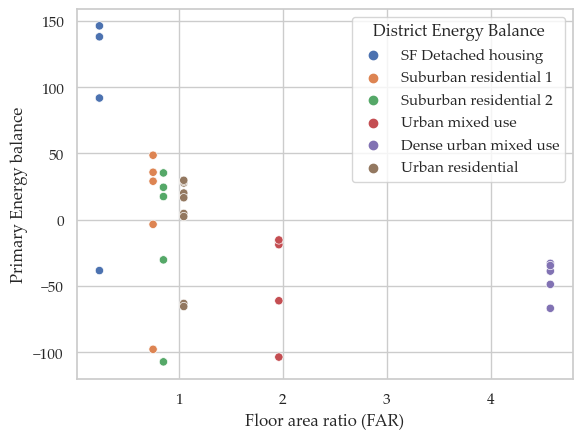

In [ ]:

sns.scatterplot(x="Floor area ratio (FAR)", y="Primary Energy balance", data=df[df.Systemgrenze=="Alpha"], hue="District Energy Balance")

In [ ]:
df

,idx,Variantenname,Simulation,Berechnungszeitpunkt,FILE,Projekt,Wohnbau NGF (m²),Büro NGF (m²),Schule NGF (m²),Kiga NGF (m²),...,Beta,Omega,Systemgrenze,id,Energiesystem,saldo_offset,PE_Saldo,District Energy Balance,Floor area ratio (FAR),Primary Energy balance
longname,,,,,,,,,,,,,,,,,,,,,
Aichinger 1 Alpha - Bauträger Standard,1,Alpha - Bauträger Standard,Doppelsimulation,2021-11-24 15:11:57,latest,Aichinger,123.8,0.0,0.0,0.0,...,,,Alpha,1,Fernwärme,0,-38.335596,SF Detached housing,0.234899,-38.335596
Aichinger 2 Alpha - Aktuell,2,Alpha - Aktuell,Doppelsimulation,2021-11-24 15:12:07,latest,Aichinger,123.8,0.0,0.0,0.0,...,,,Alpha,2,Wärmepumpe,20,91.841831,SF Detached housing,0.234899,91.841831
Aichinger 3 Alpha - Netzdienlichkeit,3,Alpha - Netzdienlichkeit,Doppelsimulation,2021-11-24 15:12:18,latest,Aichinger,123.8,0.0,0.0,0.0,...,,,Alpha,3,WP mit DSM,84,146.291772,SF Detached housing,0.234899,146.291772
Aichinger 4 Alpha - Min PEQ,4,Alpha - Min PEQ,Doppelsimulation,2021-11-24 15:12:31,latest,Aichinger,123.8,0.0,0.0,0.0,...,,,Alpha,4,WP mit DSM,84,138.033751,SF Detached housing,0.234899,138.033751
Aichinger 5 Beta - Bauträger Standard,5,Beta - Bauträger Standard,Doppelsimulation,2021-11-24 15:12:45,latest,Aichinger,123.8,0.0,0.0,0.0,...,Beta,,Beta,5,Fernwärme,0,-44.318619,SF Detached housing,0.234899,-44.318619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glan 5Mob Beta - Bauträger Standard,5Mob,Beta - Bauträger Standard,Doppelsimulation,44516.438333,latest,Glan,38994.0,0.0,0.0,502.0,...,Beta,,Beta,5,Fernwärme,0,-71.976424,Urban residential,1.046626,-71.976424
Glan 6Mob Beta - Aktuell,6Mob,Beta - Aktuell,Doppelsimulation,44516.438461,latest,Glan,38994.0,0.0,0.0,502.0,...,Beta,,Beta,6,Wärmepumpe,20,-6.228717,Urban residential,1.046626,-6.228717
Glan 7Mob Beta - Netzdienlichkeit,7Mob,Beta - Netzdienlichkeit,Doppelsimulation,44516.438646,latest,Glan,38994.0,0.0,0.0,502.0,...,Beta,,Beta,7,WP mit DSM,84,10.268391,Urban residential,1.046626,10.268391


C:\Users\Simon Schneider\AppData\Local\Temp\ipykernel_39132\344019439.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot.Variantenname = df_plot.Variantenname.str\


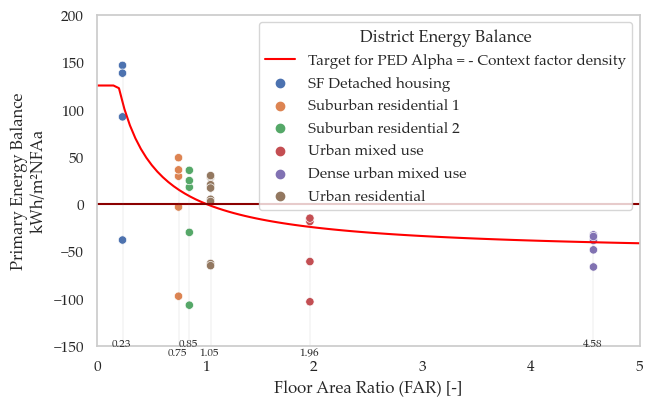

In [ ]:
zq_zielwert = Zielwert.ZQSynergy()
fsi = np.linspace(0,5,100)
zw_df = pd.DataFrame()
zw_df["Target for PED Alpha = - Context factor density"] = zq_zielwert.df(fsi)
zw_df[""] = np.zeros(len(fsi))
zw_df2 = pd.DataFrame()
zw_df2["Density context factor" "\n" "added or subtracted" "\n" "to PE-balance"] = zq_zielwert.df(fsi)
zw_df2[""] = np.zeros(len(fsi))

fig, ax = plt.subplots(1,1, figsize=(7,4.3))

target_of_gfz(ax, df=zw_df, xlims=(0,5), ylims=(-150,200), color=["red", "darkred"])
for i, proj in enumerate(df_plot.Projekt.unique()):
    df_proj = df_plot[df_plot.Projekt==proj]
    # GFZ marks
    minpeq = df_proj[df_proj["Variantenname"]=="Min PEQ"]["PE_Saldo"][0]
    gfz = df_proj.GFZ.unique()[0]

    #gfz lines
    ax.plot((gfz, gfz),(-150,minpeq), linewidth=0.1, color="grey")
    ax.text(gfz-0.1, -150-(10*(i%2)), round(gfz,2), fontsize=8)

    # min peq bubble
    #zw = zq_zielwert.alpha(gfz)
    #ax.plot((gfz, gfz), (zw, minpeq), color="red", linewidth=0.6)

    d=0
    if proj in ["Am Bichl", "Gneis"]:
        d = 20
    #beschriftung MIn PEQ
    s = f"{proj}: {round(minpeq)} (+{round(minpeq-zw)})"
    # s = f"{proj} "
    #ax.text(gfz+0.1, minpeq+d, s, fontsize=11)

df_plot = df[df.Systemgrenze=="Alpha"]
df_plot.Variantenname = df_plot.Variantenname.str\
    .replace("Alpha - ","")\
    .replace("Standard","")\
    .replace("Bauträger Standard", "Property developer" "\n" "standard")\
    .replace("Aktuell", "Current status of planning")\
    .replace("Netzdienlichkeit", "Network utility")
#    .replace("Beta - ","")\
 #   .replace("Standard","")\
  #  .replace("Min PEQ", "Min PED")\
   # .replace("Min PEQ - 75% Nutzerstrom", "Min PED - 75% User electricity demand")\
    #.replace("Bauträger", "Property developer")

    
#sns.set(font_scale=1, style="whitegrid", font="Palatino Linotype")

sns.set(font="Palatino Linotype", style="whitegrid")
sns.scatterplot(x="Floor area ratio (FAR)", y="Primary Energy balance", data=df[df.Systemgrenze=="Alpha"], hue="District Energy Balance")

ax.set_ylabel("Primary Energy Balance\nkWh/m²NFAa", font="Palatino Linotype")
ax.set_xlabel("Floor Area Ratio (FAR) [-]", font="Palatino Linotype")

# sns.scatterplot(x=2.9, y=[25, -57, -82], data=[25, -57, -82], color="blue")
# sns.scatterplot(x=4.0, y=[31, -48, -79], data=[31, -48, -79], color="blue")
# sns.scatterplot(x=1.0, y=[-24, -108, -84], data=[-24, -108, -84], color="blue")
#
# sns.scatterplot(x=1.3, y=[8, -135, -143], data=[8, -135, -143], color="green")
# sns.scatterplot(x=2.9, y=[25, -261, -286], data=[25, -261, -286], color="green")
# sns.scatterplot(x=4.0, y=[31, -141, -172], data=[31, -141, -172], color="green")
# sns.scatterplot(x=1.0, y=[-24, -238, -214], data=[-24, -238, -214], color="green")

plt.savefig("P2_zqProjects.png", dpi=300)

C:\Users\Simon Schneider\AppData\Local\Temp\ipykernel_39132\2403126934.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot.Variantenname = df_plot.Variantenname.str\


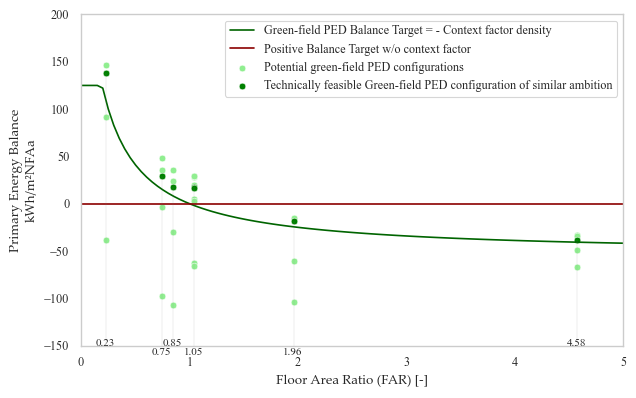

In [ ]:
zq_zielwert = Zielwert.ZQSynergy()
fsi = np.linspace(0,5,100)
zw_df = pd.DataFrame()
zw_df["Green-field PED Balance Target = - Context factor density"] = zq_zielwert.df(fsi)
zw_df["Positive Balance Target w/o context factor"] = np.zeros(len(fsi))

fig, ax = plt.subplots(1,1, figsize=(7,4.3))

sns.set("paper", font="Times new roman", style="whitegrid", )
target_of_gfz(ax, df=zw_df, xlims=(0,5), ylims=(-150,200), color=["Darkgreen", "darkred"])

for i, proj in enumerate(df_plot.Projekt.unique()):
    df_proj = df_plot[df_plot.Projekt==proj]
    # GFZ marks
    minpeq = df_proj[df_proj["Variantenname"]=="Min PEQ"]["PE_Saldo"][0]
    gfz = df_proj.GFZ.unique()[0]

    #gfz lines
    ax.plot((gfz, gfz),(-150,minpeq), linewidth=0.1, color="grey")
    ax.text(gfz-0.1, -150-(10*(i%2)), round(gfz,2), fontsize=8)

    # min peq bubble
    #zw = zq_zielwert.alpha(gfz)
    #ax.plot((gfz, gfz), (zw, minpeq), color="red", linewidth=0.6)

    d=0
    if proj in ["Am Bichl", "Gneis"]:
        d = 20
    #beschriftung MIn PEQ
    s = f"{proj}: {round(minpeq)} (+{round(minpeq-zw)})"
    # s = f"{proj} "
    #ax.text(gfz+0.1, minpeq+d, s, fontsize=11)


#sns.set(font_scale=1, style="whitegrid", font="Palatino Linotype")

df_plot = df[df.Systemgrenze=="Alpha"]
df_plot.Variantenname = df_plot.Variantenname.str\
    .replace("Alpha - ","")\
    .replace("Standard","")\
    .replace("Bauträger Standard", "Property developer" "\n" "standard")\
    .replace("Aktuell", "Current status of planning")\
    .replace("Netzdienlichkeit", "Network utility")
#    .replace("Beta - ","")\
 #   .replace("Standard","")\
  #  .replace("Min PEQ", "Min PED")\
   # .replace("Min PEQ - 75% Nutzerstrom", "Min PED - 75% User electricity demand")\
    #.replace("Bauträger", "Property developer")

sns.scatterplot(x="GFZ", y="PE_Saldo", data=df_plot, ax=ax, color="lightgreen", label="Potential green-field PED configurations")
#sns.scatterplot(x="GFZ", y="PE_Saldo", data=df_plot, ax=ax, color="lightgreen", hue="Variantenname", palette="grey")

sns.scatterplot(x="GFZ", y="PE_Saldo", data=df_plot[df_plot.Variantenname=="Min PEQ"],
                ax=ax, color="green", label="Technically feasible Green-field PED configuration of similar ambition")

ax.set_ylabel("Primary Energy Balance\nkWh/m²NFAa", font="Palatino Linotype")
ax.set_xlabel("Floor Area Ratio (FAR) [-]", font="Palatino Linotype")

# sns.scatterplot(x=2.9, y=[25, -57, -82], data=[25, -57, -82], color="blue")
# sns.scatterplot(x=4.0, y=[31, -48, -79], data=[31, -48, -79], color="blue")
# sns.scatterplot(x=1.0, y=[-24, -108, -84], data=[-24, -108, -84], color="blue")
#
# sns.scatterplot(x=1.3, y=[8, -135, -143], data=[8, -135, -143], color="green")
# sns.scatterplot(x=2.9, y=[25, -261, -286], data=[25, -261, -286], color="green")
# sns.scatterplot(x=4.0, y=[31, -141, -172], data=[31, -141, -172], color="green")
# sns.scatterplot(x=1.0, y=[-24, -238, -214], data=[-24, -238, -214], color="green")

plt.savefig("PVSEc.png", dpi=300)